# Create autoencoder to visualize latent space of lung CT scans with and without COVID-19

Code adapted from: https://douglasduhaime.com/posts/visualizing-latent-spaces.html

*Use this as a baseline to compare real images with generated images from the GAN*

Extract COVID CT images for dataset

In [0]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import zipfile
import pandas as pd
from IPython import display
from PIL import Image
from imutils import paths
import os
import glob
import cv2
from matplotlib import image

from google.colab import drive
drive.mount('/content/gdrive')

Dataset = "CT_COVID"

# !pwd
# Will unzip the files so that you can see them..
with zipfile.ZipFile("/content/gdrive/My Drive/"+Dataset+".zip","r") as z:
    z.extractall("/gdrive/Data")

from subprocess import check_output
print(check_output(["ls", "/gdrive/Data/CT_COVID"]).decode("utf8"))


# link used: https://www.pyimagesearch.com/2019/01/14/machine-learning-in-python/
os.chdir("/gdrive/Data/CT_COVID")
!pwd

path = "*.*"
data = []
for file in glob.glob(path):
  if(file.find("image_at_epoch") == -1):
    img_data = image.imread(file, 0)
    # print(img_data.shape)
    data.append(img_data)  


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/gdrive/Data/CT_COVID
2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png
2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png
2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png
2020.01.24.919183-p27-132.png
2020.01.24.919183-p27-133.png
2020.01.24.919183-p27-134.png
2020.01.24.919183-p27-135.png
2020.02.10.20021584-p6-52%0.png
2020.02.10.20021584-p6-52%10.png
2020.02.10.20021584-p6-52%11.png
2020.02.10.20021584-p6-52%12.png
2020.02.10.20021584-p6-52%13.png
2020.02.10.20021584-p6-52%14.png
2020.02.10.20021584-p6-52%15.png
2020.02.10.20021584-p6-52%1.png
2020.02.10.20021584-p6-52%2.png
2020.02.10.20021584-p6-52%3.png
2020.02.10.20021584-p6-52%4.png
2020.02.10.20021584-p6-52%5.png
2020.02.10.20021584-p6-52%6.png
2020.02.10.20021584-p6-52%7.png
2020.02.

Extract non-COVID CT scans for dataset

In [0]:
Dataset = "CT_NonCOVID"

with zipfile.ZipFile("/content/gdrive/My Drive/"+Dataset+".zip","r") as z:
    z.extractall("/gdrive/Data")

from subprocess import check_output
print(check_output(["ls", "/gdrive/Data/CT_NonCOVID"]).decode("utf8"))

# link used: https://www.pyimagesearch.com/2019/01/14/machine-learning-in-python/
os.chdir("/gdrive/Data/CT_NonCOVID")
!pwd

path = "*.*"
for file in glob.glob(path):
  if(file.find("image_at_epoch") == -1):
    img_data = image.imread(file, 0)
    # print(img_data.shape)

data = np.array(data)

/gdrive/Data/CT_COVID
0.jpg
10%0.jpg
10%1.jpg
1029.png
10%2.jpg
102.png
1030.png
103.png
1046.png
1047.png
1048.png
1049.png
104.png
1050.png
1058.png
1059.png
1060.png
1061.png
1062.png
1065.png
1070.png
1071.png
1072.png
1078.png
1079.png
1093.png
1094.png
1098.png
1099.png
1%0.jpg
1100.png
1101.png
11%0.jpg
1115.png
11%1.jpg
1123.png
1124.png
11%2.jpg
112.png
114.png
115.png
1164.png
116.png
117.png
118.png
1%1.jpg
120.png
1210.png
1211.png
1212.png
1213.png
1214.png
1215.png
1216.png
1217.png
1218.png
1221.png
1238.png
1239.png
1240.png
1261.png
1262.png
1263.png
1264.png
1277.png
1297.png
1298.png
1%2.jpg
12.jpg
1305.png
1306.png
1307.png
1308.png
1309.png
1310.png
1312.png
1313.png
1328.png
1330.png
1331.png
1332.png
1333.png
1335.png
1336.png
13.jpg
14%0.jpg
14%1.jpg
1428.png
14%2.jpg
14%3.jpg
1463.png
1497.png
1498.png
1499.png
14.png
1500.png
1501.png
15%0.jpg
15%1.jpg
15%2.jpg
15%3.jpg
1561.png
1562.png
1575.png
1576.png
1577.png
158.png
15.png
1638.png
166.png
167.png
16.jpg

Create autoencoder class

In [0]:
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten

class Autoencoder:
  def __init__(self, img_shape=(128, 128), latent_dim=2, n_layers=2, n_units=128):
    if not img_shape: raise Exception('Please provide img_shape (height, width) in px')

    # create the encoder
    i = h = Input(img_shape) # the encoder takes as input images
    h = Flatten()(h) # flatten the image into a 1D vector
    for _ in range(n_layers): # add the "hidden" layers
      h = Dense(n_units)(h) # add the units in the ith hidden layer
    o = Dense(latent_dim)(h) # this layer indicates the lower dimensional size
    self.encoder = Model(inputs=[i], outputs=[o])

    # create the decoder
    i = h = Input((latent_dim,)) # the decoder takes as input lower dimensional vectors
    for _ in range(n_layers): # add the "hidden" layers
      h = Dense(n_units)(h) # add the units in the ith hidden layer
    h = Dense(img_shape[0] * img_shape[1])(h) # one unit per pixel in inputs
    o = Reshape(img_shape)(h) # create outputs with the shape of input images
    self.decoder = Model(inputs=[i], outputs=[o])

    # combine the encoder and decoder into a full autoencoder
    i = Input(img_shape) # take as input image vectors
    z = self.encoder(i) # push observations into latent space
    o = self.decoder(z) # project from latent space to feature space
    self.model = Model(inputs=[i], outputs=[o])
    self.model.compile(loss='mse', optimizer='adam')

autoencoder = Autoencoder()

Data preprocessing: convert to grayscale, resize to 128x128, flip left to right for more dense dataset

In [0]:
from skimage.color import rgb2gray
WIDTH=128
HEIGHT=128
standardized_data = []
for img in data:
  #print(img.shape)
  img = rgb2gray(img)
  img2 = np.flip(img, axis=1) ## ADD FLIPPED IMAGE FOR LARGER DATA SET
  standardized_data.append(cv2.resize(img, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
  standardized_data.append(cv2.resize(img2, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
train_images = np.array(standardized_data)
train_images = train_images.reshape(train_images.shape[0], WIDTH,HEIGHT).astype('float32')

print(train_images.shape)

(1492, 128, 128)


Train images with autoencoder for 100 epochs

In [0]:
autoencoder.model.fit(train_images, train_images, batch_size=64, epochs=100)

Epoch 1/100
1492/1492 [==============================] - 2s 2ms/step - loss: 3439.7842
Epoch 2/100
1492/1492 [==============================] - 2s 1ms/step - loss: 779.7068
Epoch 3/100
1492/1492 [==============================] - 2s 1ms/step - loss: 451.5199
Epoch 4/100
1492/1492 [==============================] - 2s 1ms/step - loss: 330.4410
Epoch 5/100
1492/1492 [==============================] - 2s 1ms/step - loss: 309.1827
Epoch 6/100
1492/1492 [==============================] - 2s 1ms/step - loss: 275.7960
Epoch 7/100
1492/1492 [==============================] - 2s 1ms/step - loss: 251.0304
Epoch 8/100
1492/1492 [==============================] - 2s 1ms/step - loss: 243.4209
Epoch 9/100
1492/1492 [==============================] - 2s 1ms/step - loss: 239.5888
Epoch 10/100
1492/1492 [==============================] - 2s 1ms/step - loss: 243.6898
Epoch 11/100
1492/1492 [==============================] - 2s 2ms/step - loss: 243.1401
Epoch 12/100
1492/1492 [===========================

Plot latent space

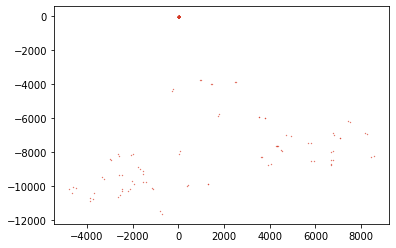

In [0]:
import matplotlib.pyplot as plt

# transform each input image into the latent space
z = autoencoder.encoder.predict(train_images)

# plot the latent space
plt.scatter(z[:,0], z[:,1], marker='o', s=0.1, c='#d53a26')
plt.show()

Sample from latent space to visualize

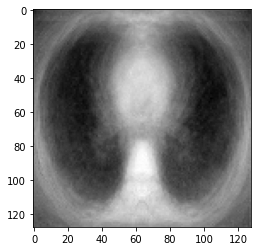

In [0]:
# sample from any coordinate region to visualize
y = np.array([[0, -110]])
prediction = autoencoder.decoder.predict(y)
plt.imshow(prediction.squeeze(), cmap='gray')

Install TensorflowJS for compatibility with HTML widget

In [0]:
!pip install -q tensorflowjs

Save models

In [0]:
import tensorflowjs as tfjs

path = !pwd
model_name = 'covidLatentSpace' # string used to define filename of saved model
autoencoder.decoder.save(model_name + '-decoder.hdf5')
tfjs.converters.save_keras_model(autoencoder.decoder, str(path))

!pwd

/gdrive/Data/CT_NonCOVID
